# Get started with pythonradex

This notebooks provides a basic pythonradex example. We will consider the non-LTE radiative transfer of CO without dust effects.

To download this notebook, click on "View page source" in the upper right.

In [1]:
from pythonradex import radiative_transfer,helpers
from scipy import constants
import matplotlib.pyplot as plt
import numpy as np

Initialise the cloud. We choose a uniform slab for the geometry and a rectangular line profile with a FWHM of 1 km/s.

In [2]:
datafilepath = './co.dat' #file downloaded from LAMDA database
geometry = 'uniform slab'
line_profile_type = 'rectangular'
width_v = 1*constants.kilo
cloud = radiative_transfer.Cloud(
                          datafilepath=datafilepath,geometry=geometry,
                          line_profile_type=line_profile_type,width_v=width_v)

Next, we need to set the parameters of the cloud. Note that pythonradex uses SI units.

In [3]:
N = 1e16/constants.centi**2 #CO column density
Tkin = 120 #kinetic temperature in [K]
collider_densities = {'para-H2':2e2/constants.centi**3,'ortho-H2':6e2/constants.centi**3}
#external background: CMB at redshift 0. For no background, simply set ext_background=0. You can also provide your
#own function for the background. It should take an array of frequencies and return
#the radiation field at those frequencies in units of W/m2/Hz/sr
ext_background = helpers.generate_CMB_background(z=0)
#no dust in this example:
T_dust = 0
tau_dust = 0
cloud.update_parameters(N=N,Tkin=Tkin,collider_densities=collider_densities,
                        ext_background=ext_background,T_dust=T_dust,tau_dust=tau_dust)

Now, we can solve the radiative transfer

In [4]:
cloud.solve_radiative_transfer()

We will now inspect the results, focussing on the 2-1 transition. As this transitions is listed 2nd in the LAMDA file, its index is 1 (the index starts with 0).

Let's first check the optical depth:

In [5]:
index_21 = 1
print(f'optical depth at line center: {cloud.tau_nu0_individual_transitions[index_21]}')

optical depth at line center: 1.3654877680371422


Turns out the 2-1 transition is optically thick. Next, let's check the excitation temperature:

In [6]:
print(f'Tex: {cloud.Tex[index_21]} K')

Tex: 20.98405060297433 K


We are clearly in the non-LTE regime: $T_\mathrm{ex}$ is much smaller than $T_\mathrm{kin}$. This is expected, because the critical density of CO 2-1 is roughly $10^5$ cm<sup>-3</sup>, which is significanlty higher than our input collider density.

Next, let us check the flux. Let us assume the source has an area of 1 au<sup>2</sup> at a distance of 100 pc.

In [7]:
area = (1*constants.au)**2
distance = 100*constants.parsec
solid_angle = area/distance**2
#in general we can get the fluxes of several transitions, but here we are only requesting 2-1, so the list of transition indices
#has only one element:
transitions = [index_21,]
flux_21 = cloud.fluxes_of_individual_transitions(solid_angle=solid_angle,transitions=transitions)
print(f'flux of CO 2-1: {flux_21} W/m2')

flux of CO 2-1: 3.502775615224129e-25 W/m2


We can also get the flux and the optical depth as functions of frequency (although in this particular case, that's not very interesting because the line profile is rectangular)

/home/gianni/science/projects/code/pythonradex/pythonradex/flux.py:235: RuntimeWarning: invalid value encountered in divide
  S_tot = np.where(self.tau_nu_tot==0,0,S_nu/self.tau_nu_tot)


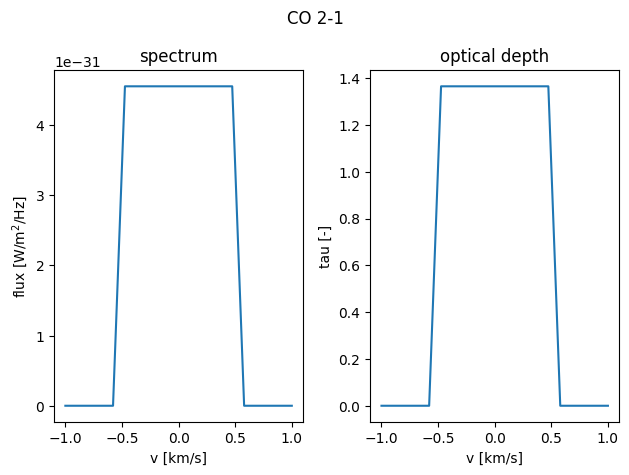

In [8]:
v = np.linspace(-width_v,width_v,20)
nu0_21 = cloud.emitting_molecule.nu0[index_21] #rest frequency of CO 2-1
nu = nu0_21*(1-v/constants.c)
spectrum = cloud.spectrum(solid_angle=solid_angle,nu=nu)
tau_nu = cloud.tau_nu(nu=nu)

fig,axes = plt.subplots(ncols=2)
fig.suptitle('CO 2-1')
axes[0].plot(v/constants.kilo,spectrum)
axes[0].set_title('spectrum')
axes[0].set_ylabel(r'flux [W/m$^2$/Hz]')
axes[1].plot(v/constants.kilo,tau_nu)
axes[1].set_title('optical depth')
axes[1].set_ylabel(r'tau [-]')
for ax in axes:
    ax.set_xlabel('v [km/s]')
fig.tight_layout()

Finally, we can also get an overview of the basic results of our calculation for all transitions by invoking the print_results function:

In [9]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      54.25       0.122061       0.330686        0.17897
   2    1     230.538000      20.98       0.330686       0.325296        1.36549
   3    2     345.795990      16.86       0.325296       0.170224        1.84636
   4    3     461.040768      13.62       0.170224      0.0431051        1.17784
   5    4     576.267931      13.49      0.0431051     0.00677658       0.314013
   6    5     691.473076      18.68     0.00677658     0.00135511      0.0461059
   7    6     806.651806      26.13     0.00135511    0.000355389     0.00844469
   8    7     921.799700      31.88    0.000355389    0.000100543     0.00212377
   9    8    1036.912393      36.25    0.000100543    2.84753e-05    0.000591351
  10    9    1151.985452      40.33    2.84753e-05    7.99171e-06    0.000165652
  11   10    1267.014486      44.10    7.99171e-06    2.20423e-06    4.62175e-05
  12   11    1381.995105   

If we want to make another calculation with updated parameters, we can use the update_parameters function again. For example, let's change the kinetic temperature while leaving the other parameters at their old values.

In [10]:
new_Tkin = 30
cloud.update_parameters(Tkin=new_Tkin)
cloud.solve_radiative_transfer()
print(f'Tex: {cloud.Tex[index_21]} K')

Tex: 13.193190911706145 K


By the way, we can of course force LTE with a high collider density.

In [11]:
LTE_collider_densities = {'para-H2':1e6/constants.centi**3,'ortho-H2':3e6/constants.centi**3}
cloud.update_parameters(collider_densities=LTE_collider_densities)
cloud.solve_radiative_transfer()
print(f'Tex of 2-1: {cloud.Tex[index_21]} K (Tkin = {new_Tkin} K)')

Tex of 2-1: 29.988740515971156 K (Tkin = 30 K)


We indeed see that now LTE is established as $T_\mathrm{ex}\approx T_\mathrm{kin}$. Of course, if it is known that LTE applies, using pythonradex to solve the radiative transfer is not necessary because the level population is known and the radiative transfer can be solved very easily and quickly.

Note that the LTE level population can be directly retrieved as follows (see also the notebook explaining how to read LAMDA files):

In [12]:
cloud.emitting_molecule.LTE_level_pop(T=new_Tkin) #the fractional population of each energy level of the CO molecule

array([8.93976938e-02, 2.23029118e-01, 2.57064475e-01, 2.06977272e-01,
       1.27278184e-01, 6.18780569e-02, 2.41922867e-02, 7.68060381e-03,
       1.99215058e-03, 4.23856103e-04, 7.41874485e-05, 1.07044890e-05,
       1.27532253e-06, 1.25614314e-07, 1.02391207e-08, 6.91270612e-10,
       3.86815058e-11, 1.79511697e-12, 6.91258932e-14, 2.20981693e-15,
       5.86710310e-17, 1.29422945e-18, 2.37289568e-20, 3.61720522e-22,
       4.58606540e-24, 4.83740681e-26, 4.24643017e-28, 3.10314390e-30,
       1.88830787e-32, 9.57116290e-35, 4.04203100e-37, 1.42265745e-39,
       4.17436752e-42, 1.02140043e-44, 2.08467998e-47, 3.55016042e-50,
       5.04602306e-53, 5.98779422e-56, 5.93383624e-59, 4.91229733e-62,
       3.39817892e-65])